## Data analytics

### Data loading for a serach word

#### data processing from DB (nltk work)

In [ ]:
import sqlite3
import pandas as pd

conn = sqlite3.connect('resources/filtered_database.db')
cursor = conn.cursor()


cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = [table[0] for table in cursor.fetchall()]


df_list = []

for table_name in tables:

    cursor.execute(f"PRAGMA table_info('{table_name}');")
    columns = [column[1] for column in cursor.fetchall()]
    
    cursor.execute(f"SELECT * FROM {table_name};")
    rows = cursor.fetchall()

    df = pd.DataFrame(rows, columns=columns)

    df['table_name'] = table_name
    

    df_list.append(df)

merged_df = pd.concat(df_list, ignore_index=True)

df = merged_df.copy()

conn.close()

In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt
import seaborn as sns


nltk.download('stopwords')

# Assuming 'df' is your DataFrame
# Preprocess the text
def preprocess(text):
    # Using regex to clean the text and then splitting into tokens
    text = re.sub(r'\W', ' ', str(text))
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    text = re.sub(r'^b\s+', '', text)
    text = text.lower()
    tokens = text.split()
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 3]
    return ' '.join(tokens)

# Apply preprocessing to the abstracts
df['processed_abstracts'] = df['abstract'].apply(preprocess)
df.to_pickle('resources/processedDF.pkl')


#### Load processed DF

In [27]:
import pandas as pd
df = pd.read_pickle('resources/processedDF.pkl')
original_df = df.copy()

### LDA topic modeling

Processing search words:   0%|          | 0/16 [00:12<?, ?it/s]


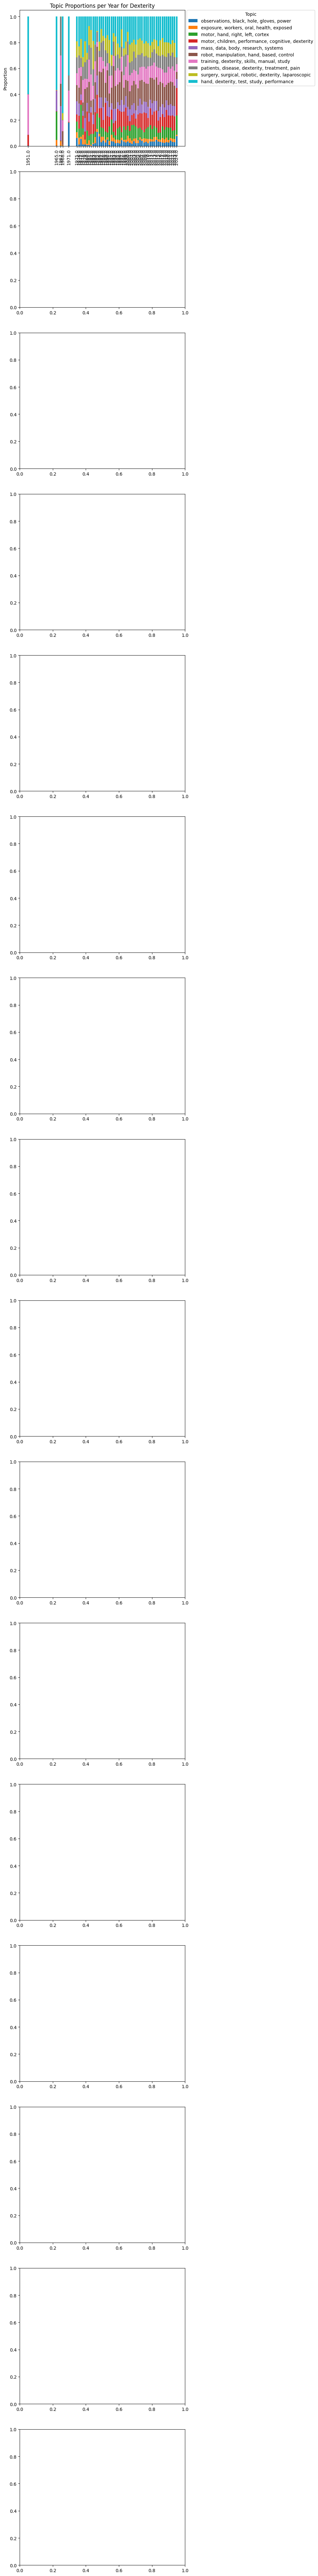

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

original_df = original_df.dropna(subset=['year', 'abstract'])
original_df['year'] = original_df['year'].astype(int)
unique_search_words = original_df['searchWord'].unique()

fig, axes = plt.subplots(16, 1, figsize=(10, 80))
axes = axes.flatten()

for idx, uw in enumerate(tqdm(unique_search_words, desc="Processing search words")):
    df = original_df[original_df['searchWord']==uw].copy()

    # Vectorize the text using CountVectorizer
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    data_vectorized = vectorizer.fit_transform(df['processed_abstracts'])

    # LDA model training
    lda_model = LatentDirichletAllocation(n_components=10, max_iter=10, learning_method='online', random_state=100)
    lda_model.fit(data_vectorized)
    theta = lda_model.transform(data_vectorized)

    # Extract top N words for each topic
    def get_top_words(model, feature_names, n_top_words):
        top_words = {}
        for topic_idx, topic in enumerate(model.components_):
            top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
            top_features = [feature_names[i] for i in top_features_ind]
            top_words[f"Topic {topic_idx+1}"] = ", ".join(top_features)
        return top_words

    top_n_words = get_top_words(lda_model, vectorizer.get_feature_names_out(), 5)

    # Create a DataFrame for topic distributions
    topic_distributions = pd.DataFrame(theta, columns=[top_n_words[f"Topic {i+1}"] for i in range(lda_model.n_components)])

    # Combine with the year information
    topic_distributions['year'] = df['year']

    # Calculate mean topic proportions per year
    mean_topic_props = topic_distributions.groupby('year').mean().reset_index()

    # Reshape data for plotting
    melted_data = pd.melt(mean_topic_props, id_vars=['year'], var_name='topic', value_name='proportion')

    # Accumulate proportions for stacking
    cumulative_proportions = np.zeros(len(mean_topic_props))

    # Plotting topic proportions per year as stacked bar chart
    for i, topic in enumerate(top_n_words.values()):
        axes[idx].bar(mean_topic_props['year'], mean_topic_props[topic], bottom=cumulative_proportions, width=0.8, label=topic)
        cumulative_proportions += mean_topic_props[topic].values

    axes[idx].set_xticks(mean_topic_props['year'])
    axes[idx].set_xticklabels(mean_topic_props['year'], rotation=90)
    axes[idx].set_ylabel('Proportion')
    axes[idx].set_title(f'Topic Proportions per Year for {uw}')
    axes[idx].legend(title='Topic', loc='upper left', bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    break

plt.tight_layout()
plt.show()

### Word2Vec-based trend visualisation

In [ ]:
from gensim.models import Word2Vec


df = merged_df.copy()
df = df.dropna(subset=['year', 'abstract'])


# Group the abstracts by year
grouped_abstracts = df.groupby('year')['processed_abstracts'].apply(list)

# Train Word2Vec models for each year
embedding_models = {}
for year, abstracts in grouped_abstracts.items():
    sentences = [abstract.split() for abstract in abstracts]
    model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
    embedding_models[year] = model



In [ ]:
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

# Get the embedding for the keyword "Dexterity" in each year
keyword = 'dexterity'
embeddings = {}
years = sorted(embedding_models.keys())

for year in years:
    model = embedding_models[year]
    if keyword in model.wv.key_to_index:
        embedding = model.wv[keyword]
        embeddings[year] = embedding


# Calculate cosine similarity between consecutive years
similarities = []
for i in range(1, len(years)):
    prev_year = years[i - 1]
    curr_year = years[i]
    if prev_year in embeddings and curr_year in embeddings:
        prev_embedding = embeddings[prev_year]
        curr_embedding = embeddings[curr_year]
        similarity = 1 - cosine(prev_embedding, curr_embedding)
        similarities.append(similarity)
    else:
        similarities.append(None)

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(years[1:], similarities, marker='o')
plt.xlabel('Year')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity of "Dexterity" Embeddings between Consecutive Years')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForMaskedLM, AdamW


# Define the dataset class
class AbstractDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        abstract = self.dataframe.iloc[idx]['processed_abstracts']
        encoding = self.tokenizer.encode_plus(
            abstract,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

# Initialize the RoBERTa tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForMaskedLM.from_pretrained('roberta-base')

# Set the device (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Create the dataset and dataloader
max_length = 128  # Adjust as needed
dataset = AbstractDataset(df, tokenizer, max_length)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Set up the optimizer, learning rate, and loss function
optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()

# Fine-tune the model
num_epochs = 3
model.train()
for epoch in range(num_epochs):
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        
        # Create masked input ids
        mask_indices = torch.bernoulli(torch.full(input_ids.shape, 0.15)).bool()
        masked_input_ids = input_ids.clone()
        target_ids = input_ids.clone()
        masked_input_ids[mask_indices] = tokenizer.mask_token_id
        
        optimizer.zero_grad()
        outputs = model(masked_input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        
        # Reshape logits and target_ids for loss calculation
        logits = logits.view(-1, tokenizer.vocab_size)
        target_ids = target_ids.view(-1)
        
        # Calculate the loss
        loss = criterion(logits, target_ids)
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# Save the fine-tuned model
model.save_pretrained('resources/fine-tuned/fine_tuned_roberta')

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForMaskedLM, AdamW

# Define the dataset class
class AbstractDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        abstract = self.dataframe.iloc[idx]['processed_abstracts']
        encoding = self.tokenizer.encode_plus(
            abstract,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

# Initialize the RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Set the device (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set up the learning rate and loss function
learning_rate = 2e-5
criterion = torch.nn.CrossEntropyLoss()

# Fine-tune the model for each year
num_epochs = 3
max_length = 1024  # Adjust as needed

# Group the DataFrame by year
grouped_df = df.groupby('year')

for year, year_df in grouped_df:
    print(f"Fine-tuning for year: {year}")
    
    # Create the dataset and dataloader for the current year
    dataset = AbstractDataset(year_df, tokenizer, max_length)
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
    
    # Initialize a new RoBERTa model for each year
    model = RobertaForMaskedLM.from_pretrained('roberta-base')
    model.to(device)
    
    # Set up the optimizer for the current year's model
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    
    # Fine-tune the model for the current year
    model.train()
    for epoch in range(num_epochs):
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            # Create masked input ids
            mask_indices = torch.bernoulli(torch.full(input_ids.shape, 0.15)).bool()
            masked_input_ids = input_ids.clone()
            target_ids = input_ids.clone()
            masked_input_ids[mask_indices] = tokenizer.mask_token_id
            
            optimizer.zero_grad()
            outputs = model(masked_input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            
            # Reshape logits and target_ids for loss calculation
            logits = logits.view(-1, tokenizer.vocab_size)
            target_ids = target_ids.view(-1)
            
            # Calculate the loss
            loss = criterion(logits, target_ids)
            loss.backward()
            optimizer.step()
        
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')
    
    # Save the fine-tuned model for the current year
    model.save_pretrained(f'resources/fine-tuned/fine_tuned_roberta_{year}')

### BERT-based trend visualisation

#### roBERTa fine-tune

In [ ]:
import nltk
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt
import seaborn as sns

df = merged_df.copy()
df = df.dropna(subset=['year', 'abstract'])

nltk.download('stopwords')

# Assuming 'df' is your DataFrame
# Preprocess the text
def preprocess(text):
    # Using regex to clean the text and then splitting into tokens
    text = re.sub(r'\W', ' ', str(text))
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    text = re.sub(r'^b\s+', '', text)
    text = text.lower()
    tokens = text.split()
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 3]
    return ' '.join(tokens)

# Apply preprocessing to the abstracts
df['processed_abstracts'] = df['abstract'].apply(preprocess)

In [ ]:
print(df[(df['year'] <= 1950) & (df['searchWord'] == 'Depression')]['abstract', 'year'])


In [ ]:
pd.set_option('display.max_colwidth', None)
print(df[(df['year'] >= 2015) & (df['searchWord'] == 'Depression')]['abstract'])


In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForMaskedLM, AdamW
import gc

# Define the dataset class
class AbstractDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        abstract = self.dataframe.iloc[idx]['processed_abstracts']
        encoding = self.tokenizer.encode_plus(
            abstract,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

# Initialize the RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Set the device (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set up the learning rate and loss function
learning_rate = 2e-5
criterion = torch.nn.CrossEntropyLoss()

# Fine-tune the model for each year
num_epochs = 50
max_length = 512

# Group the DataFrame by year
grouped_df = df.groupby('year')

for year, year_df in grouped_df:
    print(f"Fine-tuning for year: {year}")
    
    # Create the dataset and dataloader for the current year
    dataset = AbstractDataset(year_df, tokenizer, max_length)
    dataloader = DataLoader(dataset, batch_size=1024, shuffle=True)
    
    # Initialize a new RoBERTa model for each year
    model = RobertaForMaskedLM.from_pretrained('roberta-base')
    model.to(device)
    
    # Set up the optimizer for the current year's model
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    
    # Fine-tune the model for the current year
    model.train()
    for epoch in range(num_epochs):
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            # Create masked input ids
            mask_indices = torch.bernoulli(torch.full(input_ids.shape, 0.15)).bool()
            masked_input_ids = input_ids.clone()
            target_ids = input_ids.clone()
            masked_input_ids[mask_indices] = tokenizer.mask_token_id
            
            optimizer.zero_grad()
            outputs = model(masked_input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            
            # Reshape logits and target_ids for loss calculation
            logits = logits.view(-1, tokenizer.vocab_size)
            target_ids = target_ids.view(-1)
            
            # Calculate the loss
            loss = criterion(logits, target_ids)
            loss.backward()
            optimizer.step()
        
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')
    
    # Save the fine-tuned model for the current year
    model.save_pretrained(f'resources/fine-tuned/fine_tuned_roberta_{year}')
    del model
    del optimizer
    torch.cuda.empty_cache()  # Clear memory cache
    torch.cuda.synchronize()  # Wait for all kernels to finish
    gc.collect()  # Collect garbage

